In [2]:
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform

## Preprocessing data

1. Uploading abundance matrix and corresponding to samples matrix with metadata

    Abundance matrix before preproceessing has structure ( 500 samples x 1487 species ).

    Metadata contains the following data of each person: health status, age, gender, and country.

2. Filtering rare samples and bacteria using 0.01 treshold.

    Abundance matrix after filtering and preprocessing ( 449 samples × 606 species ).

In [11]:
taxanomic = pd.read_csv(
    r'data\CuratedM_Skin_all.tsv',
    sep='\t')

taxanomic.index = taxanomic.index.str.extract(r's__([^|]+)$')[0]
taxanomic = taxanomic.dropna(axis=1, how='any')
taxanomic.index.name = None

taxanomic = taxanomic.T

metadata = pd.read_csv(
    r'data\CuratedM_META_Skin_all.tsv',
    sep='\t',
    index_col=0)

metadata = metadata.reset_index()
samples_name = metadata['sample_id']
metadata.index = samples_name
metadata = metadata.drop(columns=['sample_id'])
metadata.index.name = None

In [4]:
taxanomic

,Cutibacterium_acnes,Klebsiella_pneumoniae,Propionibacterium_humerusii,Moraxella_osloensis,Enhydrobacter_aerosaccus,Staphylococcus_capitis,Klebsiella_variicola,Malassezia_restricta,Staphylococcus_caprae,Klebsiella_quasipneumoniae,...,Serratia_ureilytica,Tessaracoccus_flavescens,Cellulosimicrobium_aquatile,Pasteurella_bettyae,Staphylococcus_sp_NAM3COL9,Pseudomonas_formosensis,Stenotrophomonas_koreensis,Luteimonas_sp_83_4,Achromobacter_mucicolens,Haematobacter_genomosp_1
WBE003,30.30584,15.3888,10.55198,5.08707,3.82472,3.46621,3.07086,2.93518,2.71421,2.67323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE004,48.06613,0.0000,11.36778,2.81395,2.44343,4.60705,0.00000,5.67081,3.06033,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE005,56.04077,0.0000,2.17605,6.28136,6.32283,0.44292,0.00000,4.29156,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE006,64.18017,0.0000,0.39645,4.55770,5.78283,0.87613,0.00000,5.65499,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE007,33.25504,0.0000,12.13178,8.20376,7.78615,1.68247,0.00000,1.76710,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Steph_b2_70,62.04093,0.0000,0.00000,0.00000,0.00000,17.74540,0.00000,3.28227,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steph_b2_71,40.81936,0.0000,0.00000,0.00000,21.24264,13.81662,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steph_b2_72,15.88413,0.0000,0.00000,3.87381,6.53472,12.30439,0.00000,0.47108,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steph_b2_74,15.38284,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,1.15110,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Filter samples with insufficient taxonomic representation (containing fewer than 10% of prevalent species).
taxanomic_sum = taxanomic.astype(bool).sum(axis=1).sort_values()
threshold = taxanomic_sum.quantile(0.1)
taxanomic = taxanomic.loc[taxanomic_sum > threshold]

In [10]:
def filter_prevalence(df, threshold=0.1):
    """
    Exclude low-prevalence taxa (observed in fewer than 10% of samples) 
    """

    df_binary = (df > 0).astype(int)
    prevalence = df_binary.mean(axis=0)

    return df.loc[:, prevalence > threshold]

In [13]:
# Filter rare taxanomic and normalize by sum
filtered_taxanomic = filter_prevalence(taxanomic, threshold=0.01)
filtered_taxanomic = filtered_taxanomic.div(filtered_taxanomic.sum(axis=1), axis=0)

In [14]:
filtered_taxanomic

,Cutibacterium_acnes,Klebsiella_pneumoniae,Propionibacterium_humerusii,Moraxella_osloensis,Enhydrobacter_aerosaccus,Staphylococcus_capitis,Klebsiella_variicola,Malassezia_restricta,Staphylococcus_caprae,Klebsiella_quasipneumoniae,...,Comamonas_terrigena,Corynebacterium_auriscanis,Erwinia_gerundensis,Rahnella_aquatilis,Ochrobactrum_pituitosum,Ochrobactrum_thiophenivorans,Leuconostoc_citreum,Kluyvera_ascorbata,Pseudoxanthomonas_sp_CF385,Mycolicibacterium_bacteremicum
WBE003,0.303407,0.154065,0.105641,0.050929,0.038291,0.034702,0.030744,0.029386,0.027173,0.026763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE004,0.480661,0.000000,0.113678,0.028140,0.024434,0.046071,0.000000,0.056708,0.030603,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE005,0.560621,0.000000,0.021769,0.062838,0.063252,0.004431,0.000000,0.042932,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE006,0.641802,0.000000,0.003964,0.045577,0.057828,0.008761,0.000000,0.056550,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WBE007,0.334970,0.000000,0.122200,0.082634,0.078428,0.016947,0.000000,0.017800,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Steph_b2_64,0.002595,0.000000,0.000000,0.000000,0.000558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steph_b2_66,0.853208,0.000000,0.000000,0.000000,0.000000,0.012884,0.000000,0.038891,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steph_b2_67,0.650186,0.000000,0.000000,0.000000,0.000000,0.073643,0.000000,0.025217,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steph_b2_72,0.158841,0.000000,0.000000,0.038738,0.065347,0.123044,0.000000,0.004711,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
metadata = metadata[['disease', 'gender', 'age']]

merged_data = filtered_taxanomic.join(metadata.set_index(metadata.index), on=filtered_taxanomic.index)
merged_data = merged_data.drop(columns=['key_0'])

pd.DataFrame(merged_data).to_csv(r'data\merged_data.csv')

## Non-Negative Matrix Factorization on Microbiome Taxanomic data

In [16]:
def cosine_sim(M0, M1):
    """Calculates the cosine similarity between two matrices

    Args:
        M0 (matrix): original matrix on which the NMF was performed
        M1 (matrix): resulting matrix obtained from the multiplication of the NMF matrices
    """
    M0c = np.concatenate(np.array(M0))
    M1c = np.concatenate(np.array(M1))
    return M1c.dot(M0c) / np.sqrt(M1c.dot(M1c) * M0c.dot(M0c))

In [17]:
def get_evar(M0, M1):
    """Calculates the explained variance metric between two matrices"""
    return 1 - ( np.sum((np.array(M0)-np.array(M1))**2) / np.sum(np.array(M0)**2))

In [18]:
def run_nmf(
    original_matrix,
    alpha: float,
    divergence: str = 'kl',
    solvernmf: str = "mu",
    l1ratio: float = 0.0,
    iternb: int = 2000,
    regu: str = 'both',
    nruns: int = 100,
    random_seed: int = 10
):
    """
    Run Non-negative Matrix Factorization (NMF) on an abundance matrix.

    Args:
        original_matrix (pd.Data): Input abundance matrix (samples x features).
        alpha (float): Regularization parameter.
        divergence (str, optional): Divergence metric ('kl' or 'frobenius'). Defaults to 'kl'.
        solvernmf (str, optional): Solver for NMF ('mu' or 'cd'). Defaults to 'mu'.
        l1ratio (float, optional): L1/L2 regularization ratio. Defaults to 0.0.
        iternb (int, optional): Maximum number of iterations of NMF algorithm per run. Defaults to 2000.
        regu (str, optional): Regularization target ('w', 'h', or 'both'). Defaults to 'both'.
        nruns (int, optional): Number of runs to perform. Defaults to 1000.
        random_seed (int, optional): Random seed for reproducibility. Defaults to 10.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)

    betaloss = "kullback-leibler" if divergence == 'kl' else 'frobenius'

    # Set regularization parameters
    alpha_W = alpha if regu in ['w', 'both'] else 0
    alpha_H = alpha if regu in ['h', 'both'] else 0

    # Initialize results storage
    list_evar = []
    list_cosine = []
    list_H = []
    list_W = []

    print("Running NMF...")
    for nsig in range(2, 21):

        best_evar = -np.inf
        best_cosine = -np.inf
        best_H = None
        best_W = None

        for run in range(nruns):
            try:
                model = NMF(
                    n_components=nsig,
                    init="random",
                    solver=solvernmf,
                    beta_loss=betaloss,
                    max_iter=iternb,
                    random_state=42,
                    alpha_W=alpha_W,
                    alpha_H=alpha_H,
                    l1_ratio=l1ratio,
                    verbose=False
                )
                H = model.fit_transform(original_matrix.T).T
                W = model.components_.T

                reconstructed_matrix = W.dot(H)
                evar = get_evar(original_matrix, reconstructed_matrix)
                cosine = cosine_sim(original_matrix, reconstructed_matrix)

                if cosine > best_cosine:
                    best_evar = evar
                    best_cosine = cosine
                    best_H = H
                    best_W = W

            except Exception as e:
                print(f"Error during run with signature number {nsig}: {e}")
                continue
            
        list_evar.append(best_evar)
        list_cosine.append(best_cosine)
        list_H.append(best_H)
        list_W.append(best_W)
        print(f"Signature {nsig} completed.")

    if list_H is None or list_W is None:
        raise RuntimeError("All NMF runs failed. Check your input parameters or data.")

    print("NMF completed.")

    return list_evar, list_cosine, list_W, list_H

In [19]:
list_evar, list_cosine, list_W, list_H = run_nmf(filtered_taxanomic, alpha=0, nruns=1)

Running NMF...
Signature 2 completed.
Signature 3 completed.
Signature 4 completed.
Signature 5 completed.
Signature 6 completed.
Signature 7 completed.
Signature 8 completed.
Signature 9 completed.
Signature 10 completed.
Signature 11 completed.
Signature 12 completed.
Signature 13 completed.
Signature 14 completed.
Signature 15 completed.
Signature 16 completed.
Signature 17 completed.
Signature 18 completed.
Signature 19 completed.
Signature 20 completed.
NMF completed.


In [21]:
# Saving NMF results
for i in range(len(list_W)):
    W = list_W[i]
    H = list_H[i]
    pd.DataFrame(W, index=filtered_taxanomic.index).to_csv(f'results_NMF\W_{i+2}.csv')
    pd.DataFrame(H, columns=filtered_taxanomic.columns).to_csv(f'results_NMF\H_{i+2}.csv')

## Find optimal number of signatures

Approach - find the point of the line with maximum curvature on a line, using Kneedle algorithm. 

In [22]:
cosine_sim = pd.read_csv(r'results_NMF\cosine_similarities.csv', index_col=0)
exp_varience = pd.read_csv(r'results_NMF\explained_variance.csv', index_col=0)

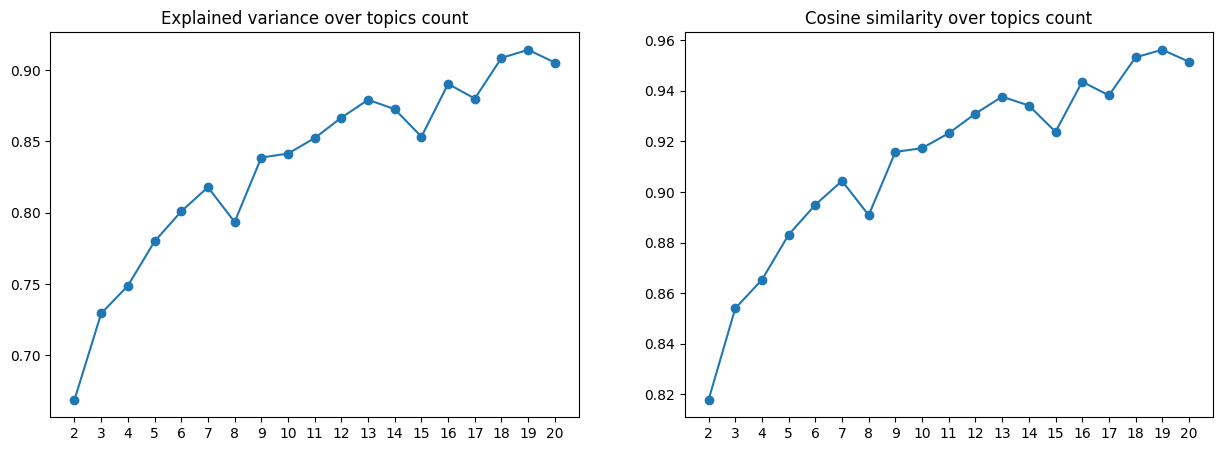

In [23]:
plt.figure(figsize=(15, 5))

x = [i for i in range(2, len(exp_varience)+2, 1)]   

plt.subplot(1,2,1)
plt.plot(x, exp_varience, marker='o')
plt.xticks(x) 
plt.title('Explained variance over topics count')

plt.subplot(1,2,2)
plt.plot(x, cosine_sim, marker='o')
plt.xticks(x) 
plt.title('Cosine similarity over topics count')
plt.show()

In [24]:
from kneed import KneeLocator

x_array = np.array(x)
exp_varience_array = np.array(exp_varience)
cosine_sim_array = np.array(cosine_sim)

# to make sure arrays are 1D 
if x_array.ndim != 1 or exp_varience_array.ndim !=  1 or cosine_sim_array.ndim != 1:
    x_array = x_array.flatten()
    exp_varience_array = exp_varience_array.flatten()
    cosine_sim_array = cosine_sim_array.flatten()

# If ‘concave’, algorithm will detect knees. If ‘convex’, it will detect elbows.
kneedle_evar = KneeLocator(x_array, exp_varience_array, S=1.0, curve="concave", direction="increasing")
kneedle_sim = KneeLocator(x_array, cosine_sim_array, S=1, curve="concave", direction="increasing")
print(f"Optimal number of topics based on explained variance: {kneedle_evar.elbow} and cosine similarity: {kneedle_sim.elbow}")

Optimal number of topics based on explained variance: 7 and cosine similarity: 7


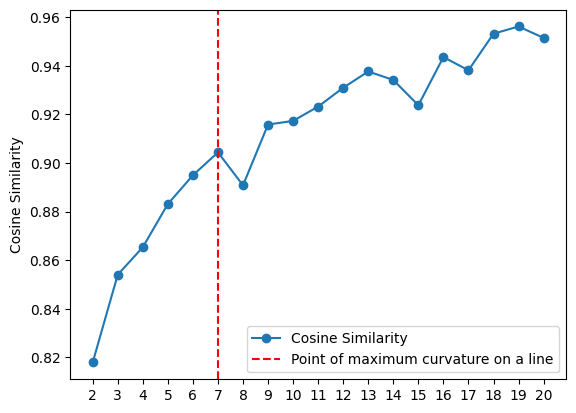

In [25]:
plt.plot(x, cosine_sim, marker='o', label='Cosine Similarity')
plt.axvline(x=kneedle_sim.elbow, color='r', linestyle='--', label='Point of maximum curvature on a line')
plt.xticks(x) 
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

As we can see, curve has noise and is non-linear and 'true' knee is obscured by small fluctuations. So here can be helpfull using Polynomial Interpolation. 

First and second defree are linear and quadratic and miss knees in trends. Good choice would be 4, 5 and 6 degree, but the higher count also means overfitting, so here i choose 5 polynomial degree.

Optimal number of topics based on explained variance: 7 and cosine similarity: 7


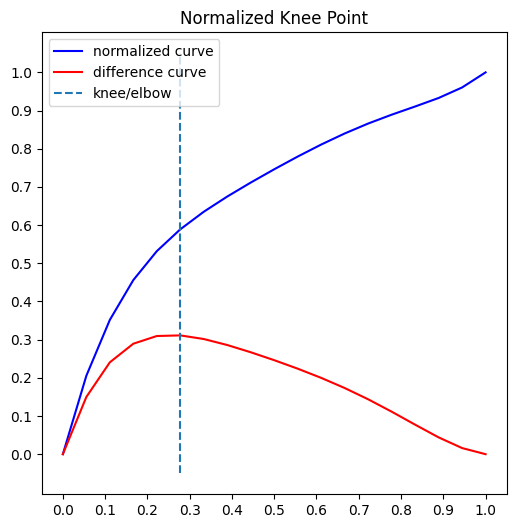

In [26]:
kneedle_evar_smooth = KneeLocator(x_array, exp_varience_array, S=1.0, curve="concave", direction="increasing",  interp_method="polynomial", polynomial_degree=5)
kneedle_sim_smooth = KneeLocator(x_array, cosine_sim_array, S=1.0, curve="concave", direction="increasing",  interp_method="polynomial", polynomial_degree =5)

print(f"Optimal number of topics based on explained variance: {kneedle_evar_smooth.elbow} and cosine similarity: {kneedle_sim_smooth.elbow}")
TOPICS = kneedle_sim_smooth.elbow

kneedle_sim_smooth.plot_knee_normalized()

## Export NMF results and metadata 

In [27]:
H_path = r'results_NMF\H_{}.csv'.format(TOPICS)
W_path = r'results_NMF\W_{}.csv'.format(TOPICS)
H = pd.read_csv(H_path, index_col=0)
W = pd.read_csv(W_path, index_col=0)

W = W.div(W.sum(axis=1), axis=0)
H = H.div(H.sum(axis=1), axis=0)

H.index = [i for i in range(1, TOPICS + 1)]
W.columns = [i for i in range(1, TOPICS + 1)]

data = pd.read_csv(r'data\merged_data.csv', index_col=0)

## NMF results analysis

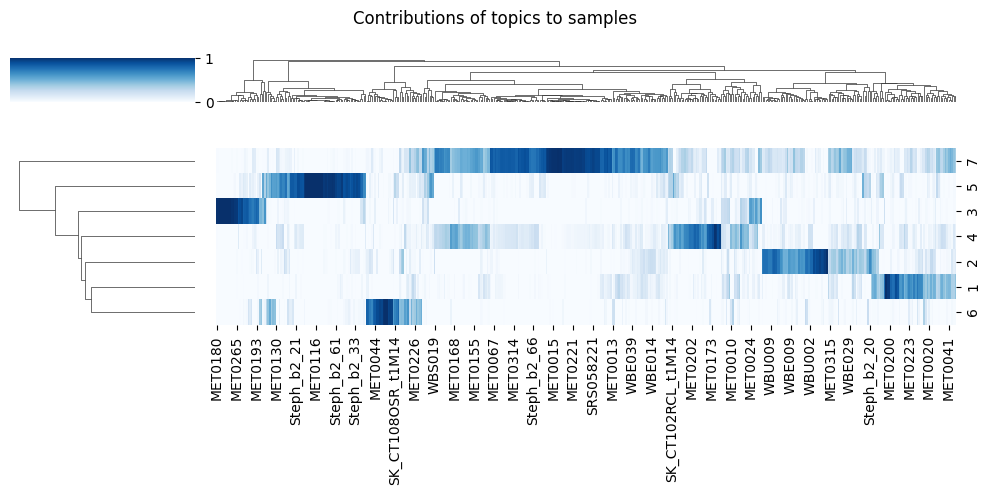

In [ ]:
# Create a     огр
g = sns.clustermap(W.T, 
                   figsize=(10, 5), 
                   cmap='Blues'
                   )

g.fig.suptitle('Contributions of topics to samples')

plt.tight_layout()
plt.show()

In [41]:
def visualize_topic_contributions(H_df, n_top_species=5):
    """
    Visualize the top contributing species for each topic using a heatmap.
    
    Parameters:
    -----------
    H_matrix : numpy.ndarray
        The H matrix from NMF decomposition
    species_names : list or Index
        List of species names corresponding to H matrix columns
    n_top_genera : int, default=5
        Number of top species to show for each topic
    n_topics : int, default=5
        Number of topics to visualize
    output_path : str, default='taxonomic_nmf.png'
        Path where to save the output figure
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the top species contributions for each topic
    """
    n_topics = TOPICS
    
    # Initialize DataFrame to store top species
    top_species_df = pd.DataFrame()
    top_species_dict = {}

    # Multiply H_df by 100 to get percentage contributions
    H_df = H_df * 100
    
    # Get top species for each topic
    for topic in range(1, n_topics+1):
        top_for_topic = H_df.T[[topic]].sort_values(by=[topic], ascending=False).head(n_top_species)
        top_species_df = pd.concat([top_species_df, top_for_topic], axis=1)
        top_species_dict[topic] = top_for_topic
    
    # Rename columns to meaningful topic names
    top_species_df.columns = [f'Topic {i}' for i in range(1, n_topics+1)]
    
    # Create visualization
    plt.figure(figsize=(10, 10))
    sns.heatmap(top_species_df.fillna(0), 
                cmap='Blues',
                annot=True,
                fmt='.3f',
                cbar_kws={'label': 'Contribution Strength'})
    
    plt.title('Species Contribution in Each Topic', pad=10)
    plt.xlabel('Topics')
    plt.tight_layout()
    
    # Save the figure
    #plt.savefig(f'{output_path}nmf_taxoomy.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return top_species_dict

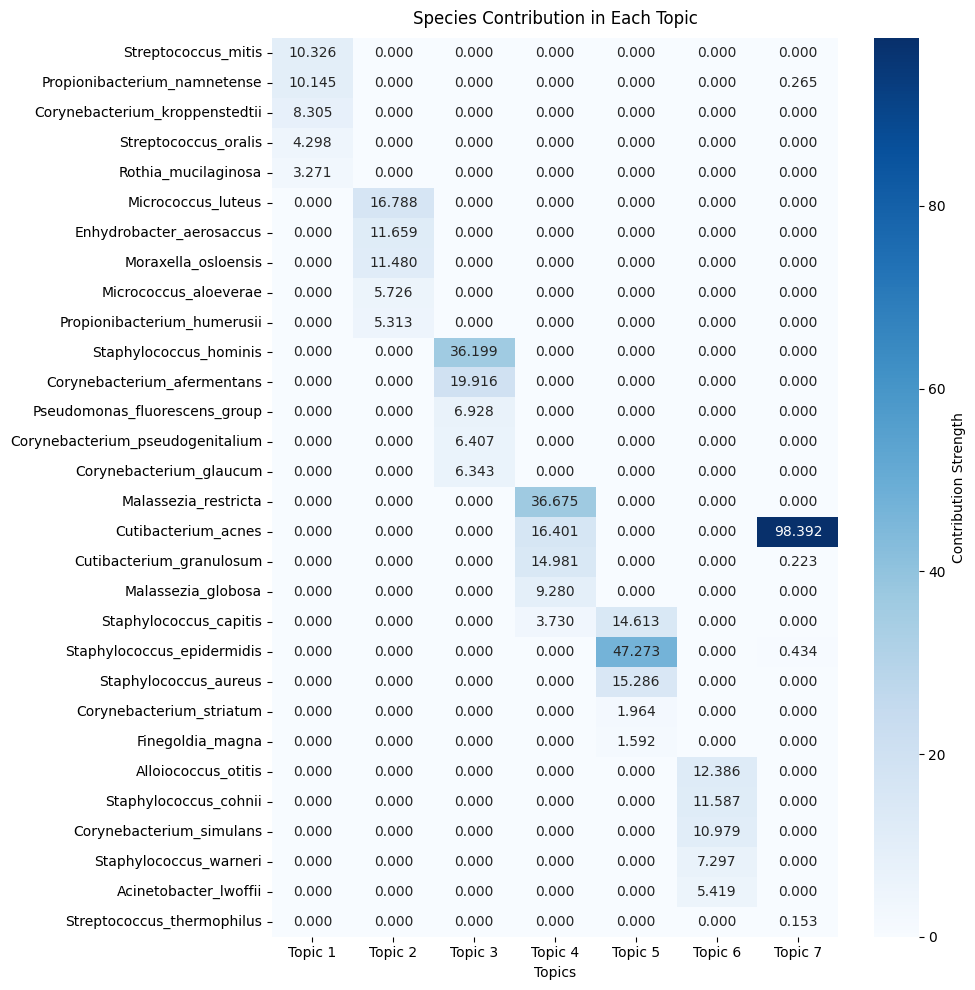

In [42]:
top_functions= visualize_topic_contributions(
    H_df=H,
    n_top_species = 5
)

In [33]:
with open(f'top_functions_{TOPICS}.txt', 'w') as f:
    for s in top_functions:
        functions = top_functions[s]
        f.write(f'Topic {s}: \n {functions} \n\n')

### Now, let's examine how health statuses (AD, psoriasis, and healthy samples) and age are distributed across each of the 7 signatures.

In [36]:
# Create a DataFrame for the W matrix
W_df = pd.DataFrame(W)

# Add features to the DataFrame
W_df['diagnosis'] = [data['disease'].get(sample) for sample in W_df.index]
W_df['age'] = [data['age'].get(sample) for sample in W_df.index]

# Process psoriasis rows
psoriasis_mask = W_df['diagnosis'].str.contains('psoriasis', case=False)
W_df.loc[psoriasis_mask, 'diagnosis'] = 'psoriasis'

# Process AD rows (after psoriasis processing to avoid overlap)
ad_mask = W_df['diagnosis'].str.contains('AD', case=False)
W_df.loc[ad_mask, 'diagnosis'] = 'AD'

# Filter out rows with 'AR' or 'arthritis' in diagnosis column
W_df = W_df[~W_df['diagnosis'].str.contains('arthritis', case=False, regex=False)]
W_df = W_df[~W_df['diagnosis'].str.contains('AR', case=False, regex=False)]

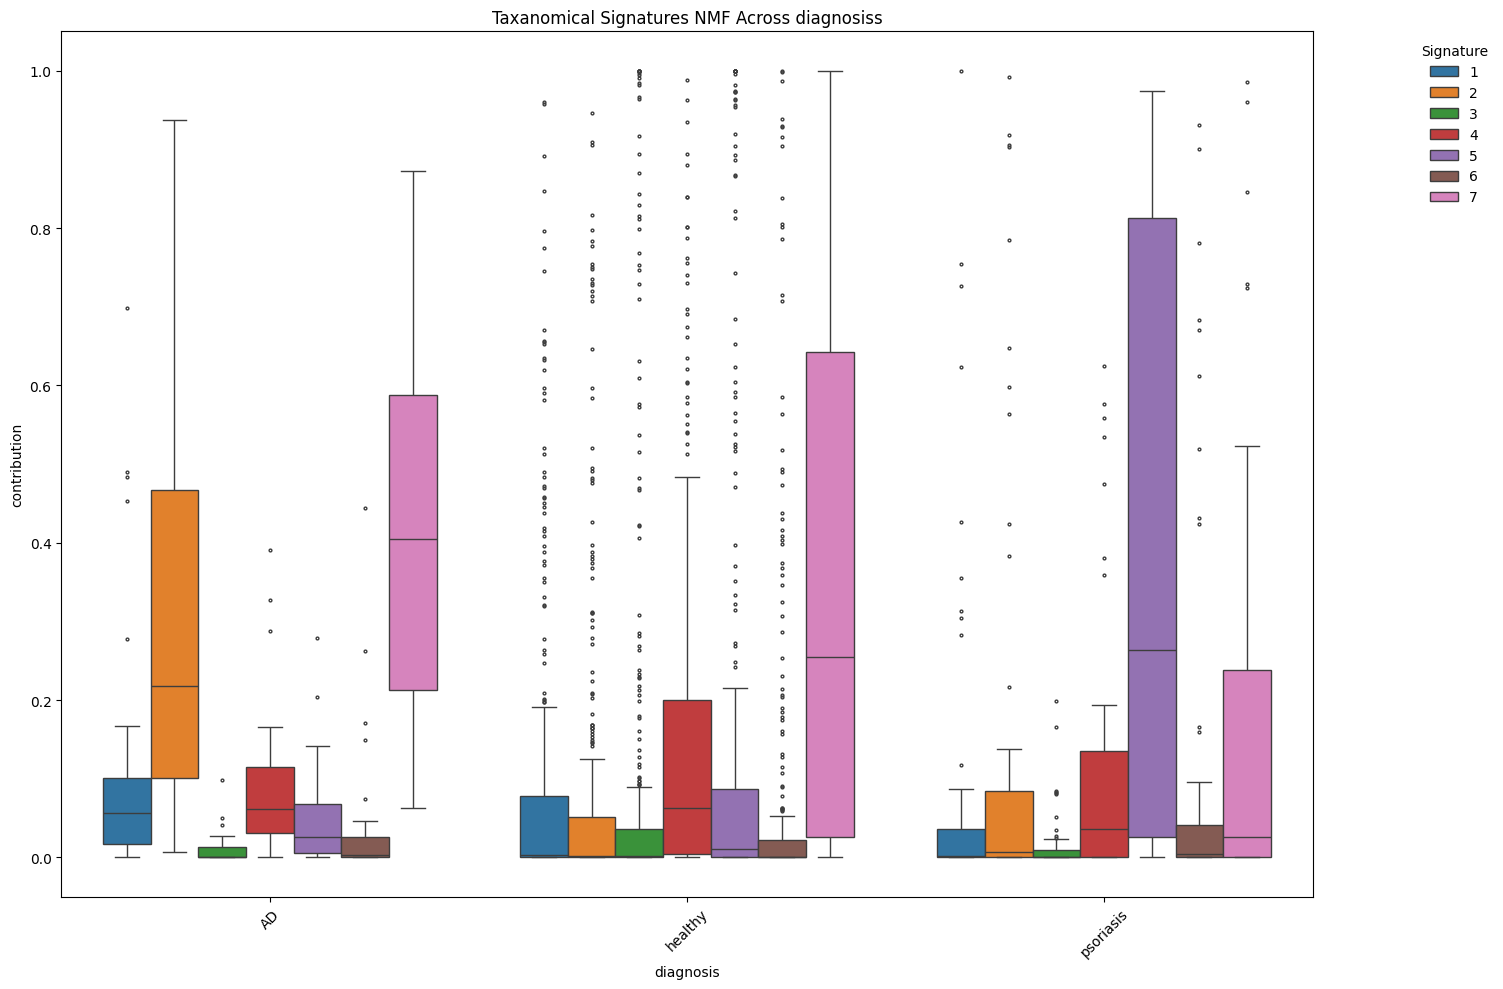

In [37]:
df_diagnosis = W_df.drop(columns=['age'])
df_diagnosis = df_diagnosis.set_index('diagnosis').stack().reset_index()
df_diagnosis.columns = ['diagnosis', 'signature', 'contribution']

plt.figure(figsize=(15, 10))
sns.boxplot(x='diagnosis', y='contribution', hue='signature', palette='tab10', data=df_diagnosis, fliersize=2)
plt.xticks(rotation=45)

plt.title('Taxanomical Signatures NMF Across diagnosiss')
plt.legend(bbox_to_anchor=(1.15, 1), title='Signature', edgecolor='w')

plt.tight_layout()
plt.show()

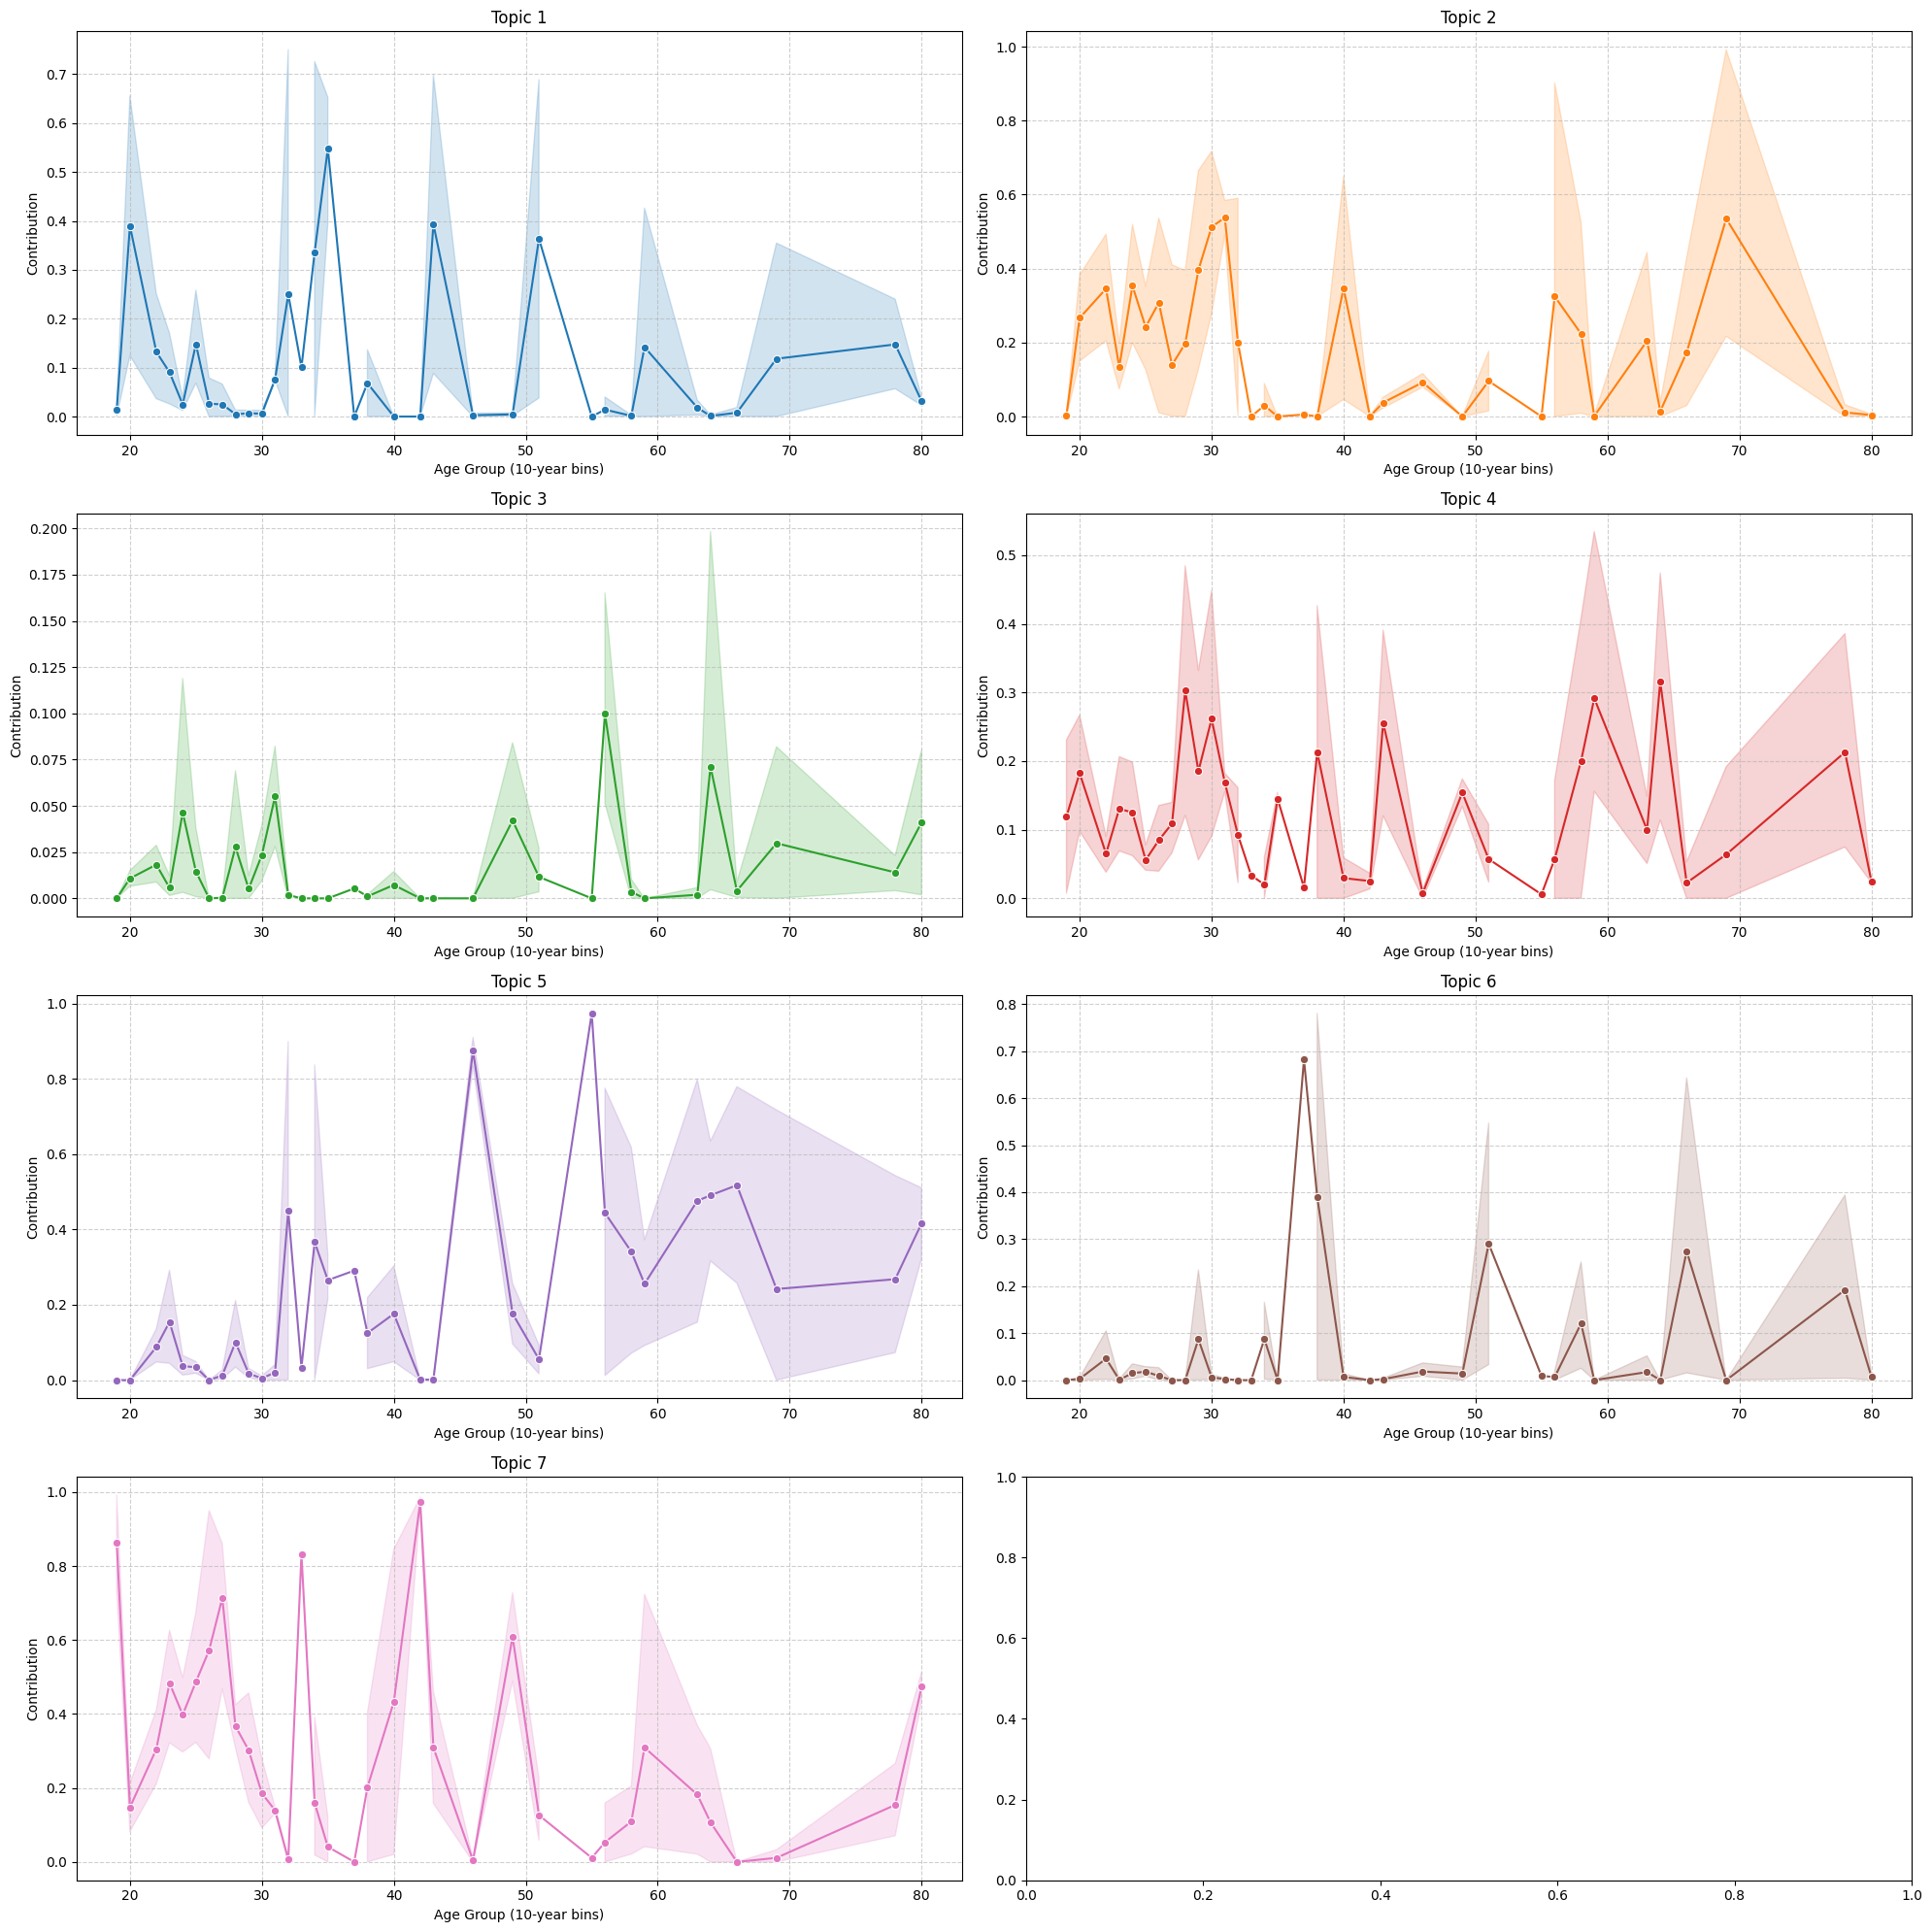

In [38]:
df_age = W_df.drop(columns=['diagnosis'])
df_age = df_age.set_index('age').stack().reset_index()
df_age.columns = ['age', 'signature', 'contribution']

signatures = [i for i in range(1, TOPICS + 1)]
palette = sns.color_palette('tab10', n_colors=TOPICS)
color_dict = dict(zip(signatures, palette)) 

nrows = len(signatures) // 2 + (len(signatures) % 2 > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 20))
axes = axes.flatten()

for i, sig in enumerate(signatures):
    ax = axes[i]
    topic_data = df_age[df_age['signature'] == sig]
    
    sns.lineplot(
        data=topic_data,
        x='age',
        y='contribution',
        color=color_dict[sig],
        marker='o',
        ax=ax
    )
    
    ax.set_title(f'Topic {sig}', fontsize=12)
    ax.set_xlabel('Age Group (10-year bins)')
    ax.set_ylabel('Contribution')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()